In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from llama_cpp import Llama
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from pprint import pprint

In [2]:
# Load the model
model_name = "llama3.2:1b"
model_path = "/Users/jimyhc/.ollama/models/blobs/sha256-74701a8c35f6c8d9a4b91f3f3497643001d63e0c7a84e085bed452548fa88d45"

llm = Llama(
    model_path=model_path,
    n_threads=4,
    n_ctx=2048,
    embedding=True,
    verbose=False
)

llama_init_from_model: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_

In [45]:
sql_examples = []

with open('dev.sql', 'r') as f:
    lines = f.readlines()

i = 0
while i < len(lines):
    line = lines[i].strip()
    
    if line.startswith("Question"):
        # Extract natural language part
        if "|||" in line:
            nl_part = line.split("|||")[0].split(":", 1)[1].strip()
        else:
            i += 1
            continue
        
        # The next line should be the SQL
        i += 1
        if i < len(lines) and lines[i].strip().lower().startswith("sql:"):
            sql_part = lines[i].split(":", 1)[1].strip()
            sql_examples.append({
                "natural_language": nl_part,
                "sql_query": sql_part
            })
    i += 1

print(len(sql_examples))
print(sql_examples[0])

1034
{'natural_language': 'How many singers do we have ?', 'sql_query': 'select count(*) from singer'}


In [4]:
# Function to get embeddings with detailed diagnostics
def get_embeddings(llm, texts, description="", verbose=False):
    """Extract embeddings for a list of texts with detailed diagnostics"""
    print(f"\n--- Extracting embeddings for {description} ---")
    embeddings = []
    
    for i, text in enumerate(tqdm(texts)):
        try:
            response = llm.embed(text)[-1]
            
            # First time only: print detailed diagnostic information
            if verbose:
                print(f"Embedding type: {type(response)}")
                print(f"Embedding shape: {len(response)}")
                if isinstance(response, list):
                    print(f"Element type: {type(response[0])}")
                    print(f"First 5 values: {response[:5]}")
                    print(f"Last 5 values: {response[-5:]}")
                    print(f"Min value: {min(response)}")
                    print(f"Max value: {max(response)}")
                    print(f"Mean value: {np.mean(response)}")
                    print(f"Standard deviation: {np.std(response)}")
                
            # Convert to numpy array for easier manipulation
            embedding_array = np.array(response)
            embeddings.append(embedding_array)
            
        except Exception as e:
            print(f"Error extracting embedding for text {i}: {e}")
            print(f"Text: {text[:100]}...")
    
    # Create a combined array of all embeddings
    embeddings_matrix = np.vstack(embeddings)
    print(f"Combined embeddings matrix shape: {embeddings_matrix.shape}")
    
    return embeddings, embeddings_matrix

In [5]:
# Extract natural language questions and SQL queries as separate lists
nl_questions = [example["natural_language"] for example in sql_examples]
sql_queries = [example["sql_query"] for example in sql_examples]
full_queries = [example["natural_language"] + "\n" + example["sql_query"] for example in sql_examples]

# Get embeddings for both natural language and SQL queries
nl_embeddings, nl_matrix = get_embeddings(llm, nl_questions, "natural language questions")
sql_embeddings, sql_matrix = get_embeddings(llm, sql_queries, "SQL queries")
full_embeddings, full_matrix = get_embeddings(llm, full_queries, "Full queries")


--- Extracting embeddings for natural language questions ---


  0%|          | 0/1034 [00:00<?, ?it/s]

Combined embeddings matrix shape: (1034, 2048)

--- Extracting embeddings for SQL queries ---


  0%|          | 0/1034 [00:00<?, ?it/s]

Combined embeddings matrix shape: (1034, 2048)

--- Extracting embeddings for Full queries ---


  0%|          | 0/1034 [00:00<?, ?it/s]

Combined embeddings matrix shape: (1034, 2048)


In [6]:
# Function to analyze and visualize embedding space
def analyze_embedding_space(embeddings_matrix, labels=None, title="Embedding Space Analysis"):
    """Analyze the structure of the embedding space using PCA and visualization"""
    print(f"\n--- {title} ---")
    
    # Check for NaN values or other issues
    print(f"Any NaN values: {np.isnan(embeddings_matrix).any()}")
    print(f"Any infinite values: {np.isinf(embeddings_matrix).any()}")
    
    # Compute basic statistics
    print(f"Embedding matrix shape: {embeddings_matrix.shape}")
    print(f"Mean vector magnitude: {np.mean(np.linalg.norm(embeddings_matrix, axis=1))}")
    
    # Compute pairwise cosine similarities
    similarities = cosine_similarity(embeddings_matrix)
    np.fill_diagonal(similarities, 0)  # Zero out self-similarities
    
    print(f"Average cosine similarity: {np.mean(similarities)}")
    print(f"Max cosine similarity: {np.max(similarities)}")
    print(f"Min cosine similarity: {np.min(similarities)}")
    
    # Plot similarity heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarities, annot=True if len(similarities) < 10 else False)
    plt.title(f"Cosine Similarity Heatmap - {title}")
    plt.show()
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(embeddings_matrix)
    
    # Show explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title(f'PCA Explained Variance - {title}')
    plt.xticks(range(1, min(11, len(explained_variance) + 1)))
    plt.axhline(y=0.9, color='k', linestyle='--')
    plt.show()
    
    # Find how many components explain 90% of variance
    components_90pct = np.argmax(cumulative_variance >= 0.9) + 1
    print(f"Number of components explaining 90% of variance: {components_90pct}")
    
    # If we have more than 2 samples, visualize in 2D
    if embeddings_matrix.shape[0] > 2:
        # Plot first two PCA components
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1])
        
        # Add labels if provided
        if labels is not None:
            for i, label in enumerate(labels):
                plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]))
        
        plt.title(f'PCA Visualization - {title}')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.grid()
        plt.show()
    
    return pca, pca_result, components_90pct


--- Natural Language Questions ---
Any NaN values: False
Any infinite values: False
Embedding matrix shape: (1034, 2048)
Mean vector magnitude: 96.03799393201454
Average cosine similarity: 0.6501059570297355
Max cosine similarity: 0.9961577510831097
Min cosine similarity: 0.0


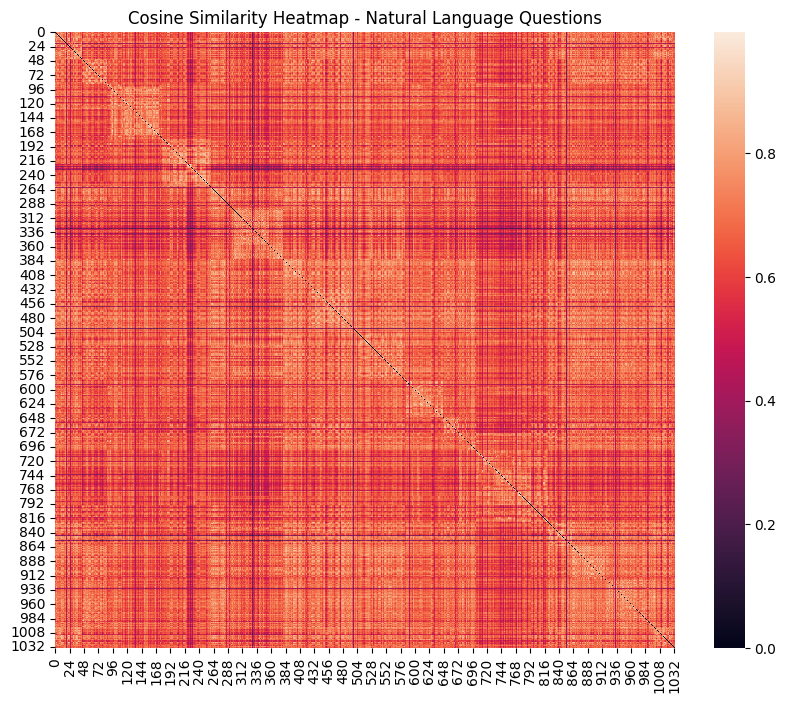

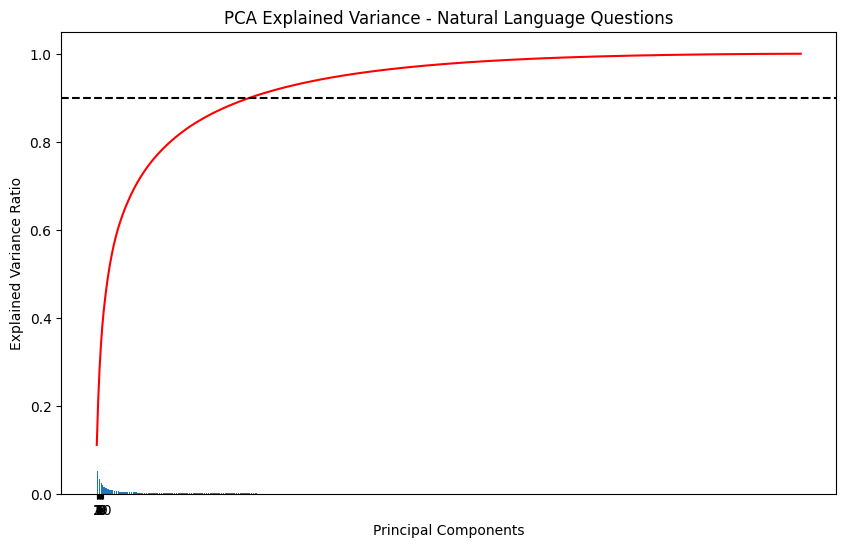

Number of components explaining 90% of variance: 226


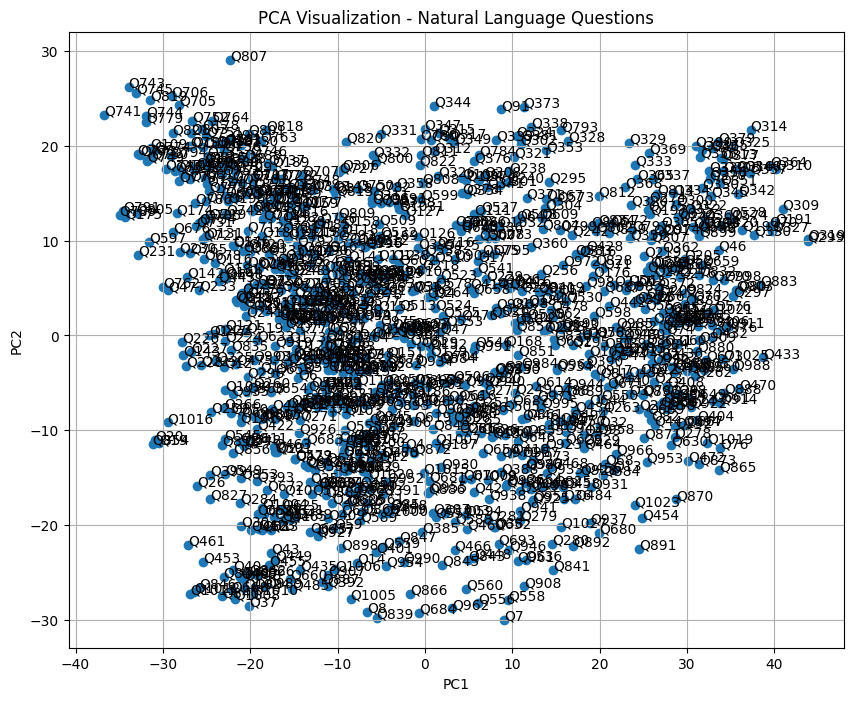


--- SQL Queries ---
Any NaN values: False
Any infinite values: False
Embedding matrix shape: (1034, 2048)
Mean vector magnitude: 102.2685261154244
Average cosine similarity: 0.5727725333834668
Max cosine similarity: 1.0000000000000029
Min cosine similarity: 0.0


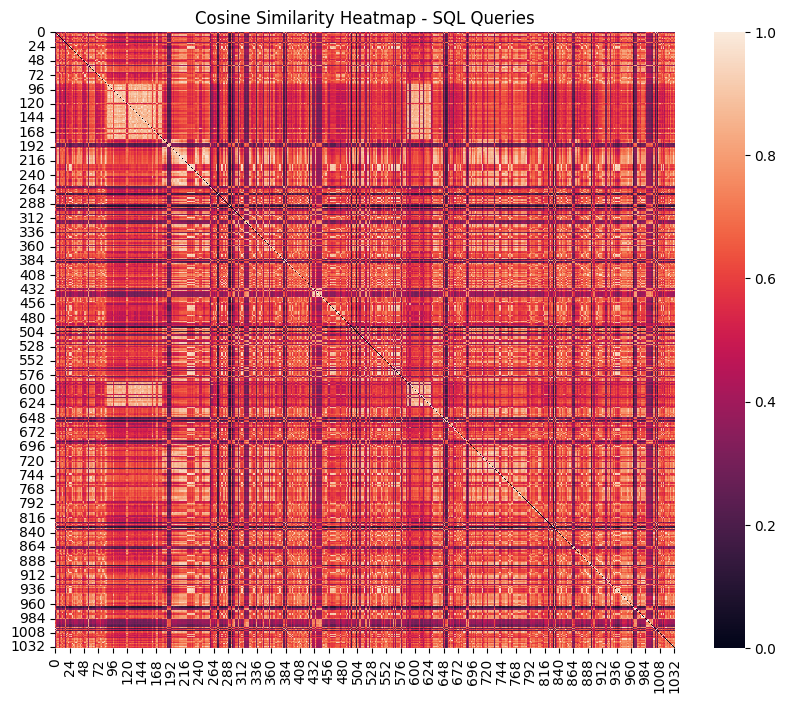

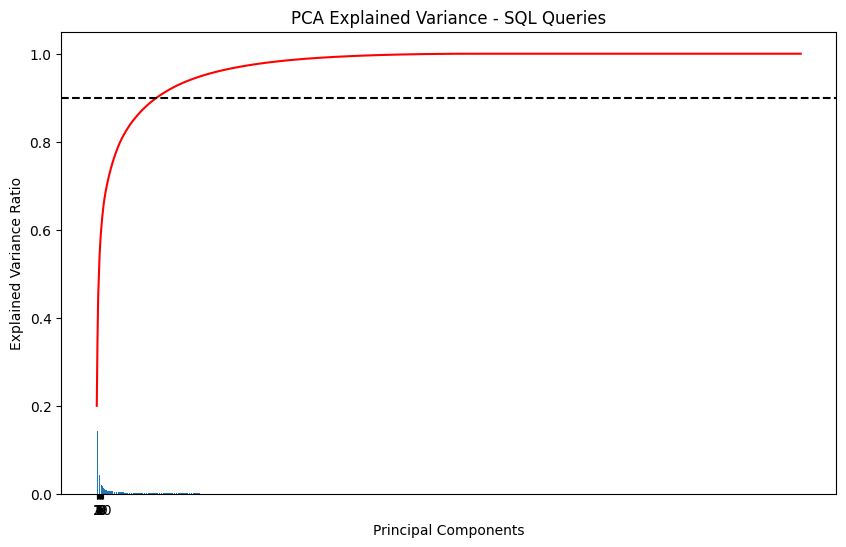

Number of components explaining 90% of variance: 89


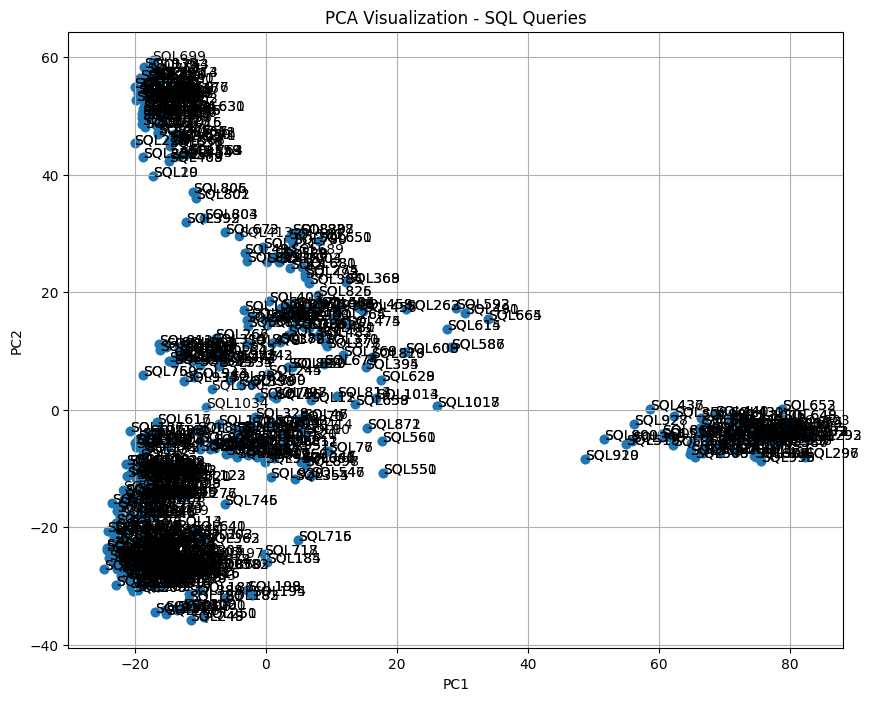

In [7]:
# Analyze embedding spaces
pca_nl, pca_result_nl, components_nl = analyze_embedding_space(nl_matrix, 
                                                             labels=[f"Q{i+1}" for i in range(len(nl_questions))],
                                                             title="Natural Language Questions")

pca_sql, pca_result_sql, components_sql = analyze_embedding_space(sql_matrix,
                                                                labels=[f"SQL{i+1}" for i in range(len(sql_queries))],
                                                                title="SQL Queries")

In [36]:
# Function to simulate the optimal prompt selection process
def select_optimal_prompts(embeddings_matrix, n_prompts=1000):
    """
    Select n_prompts that best span the embedding space
    Uses a greedy approach based on maximizing orthogonality
    """
    print(f"\n--- Selecting {n_prompts} Optimal Prompts ---")
    
    # Normalize all embeddings
    normalized_embeddings = embeddings_matrix / np.linalg.norm(embeddings_matrix, axis=1)[:, np.newaxis]
    
    # Start with the embedding that has the largest norm
    norms = np.linalg.norm(embeddings_matrix, axis=1)
    selected_indices = [np.argmax(norms)]
    selected_embeddings = [normalized_embeddings[selected_indices[0]]]
    
    # Greedily select embeddings that are most orthogonal to already selected ones
    for i in range(1, min(n_prompts, len(embeddings_matrix))):
        similarities = np.zeros(len(normalized_embeddings))
        
        # Calculate maximum similarity to any already selected embedding
        for j in range(len(normalized_embeddings)):
            if j in selected_indices:
                similarities[j] = float('inf')  # Don't select already chosen embeddings
            else:
                max_similarity = 0
                for selected_embedding in selected_embeddings:
                    similarity = np.abs(np.dot(normalized_embeddings[j], selected_embedding))
                    max_similarity = max(max_similarity, similarity)
                similarities[j] = max_similarity
        
        # Select the one with minimum maximum similarity (most orthogonal)
        next_index = np.argmin(similarities)
        selected_indices.append(next_index)
        selected_embeddings.append(normalized_embeddings[next_index])
        
        print(f"Selected prompt {i+1}: index {next_index}")
    
    return selected_indices

In [37]:
# Select optimal prompts
selected_nl_indices = select_optimal_prompts(nl_matrix)
print("\nSelected natural language prompts:")
for idx in selected_nl_indices:
    print(f"- {nl_questions[idx]}")


--- Selecting 1000 Optimal Prompts ---
Selected prompt 2: index 329
Selected prompt 3: index 260
Selected prompt 4: index 134
Selected prompt 5: index 845
Selected prompt 6: index 798
Selected prompt 7: index 225
Selected prompt 8: index 497
Selected prompt 9: index 934
Selected prompt 10: index 655
Selected prompt 11: index 343
Selected prompt 12: index 252
Selected prompt 13: index 25
Selected prompt 14: index 931
Selected prompt 15: index 769
Selected prompt 16: index 460
Selected prompt 17: index 632
Selected prompt 18: index 728
Selected prompt 19: index 1010
Selected prompt 20: index 852
Selected prompt 21: index 139
Selected prompt 22: index 108
Selected prompt 23: index 504
Selected prompt 24: index 935
Selected prompt 25: index 712
Selected prompt 26: index 938
Selected prompt 27: index 720
Selected prompt 28: index 181
Selected prompt 29: index 751
Selected prompt 30: index 591
Selected prompt 31: index 404
Selected prompt 32: index 475
Selected prompt 33: index 614
Selected

In [38]:
# Now let's evaluate if our selected prompts effectively span the space
# We can use PCA to compare the subspace spanned by selected prompts vs. all prompts
def evaluate_prompt_coverage(full_matrix, selected_indices, title="Prompt Coverage Evaluation"):
    """Evaluate how well the selected prompts cover the full embedding space"""
    print(f"\n--- {title} ---")
    
    # Get the selected embeddings
    selected_embeddings = full_matrix[selected_indices]
    
    # Perform PCA on the selected embeddings
    pca_selected = PCA()
    pca_selected.fit(selected_embeddings)
    
    # Project the full embedding set onto the principal components of the selected set
    # First, we need to determine how many components to use
    explained_var_selected = np.cumsum(pca_selected.explained_variance_ratio_)
    n_components = np.argmax(explained_var_selected >= 0.9) + 1
    n_components = min(n_components, min(selected_embeddings.shape))
    
    print(f"Number of components explaining 90% of selected prompts variance: {n_components}")
    
    # Project all embeddings onto the selected embeddings' principal components
    components = pca_selected.components_[:n_components]
    projected = np.dot(full_matrix, components.T)
    reconstructed = np.dot(projected, components)
    
    # Calculate reconstruction error
    mse = np.mean(np.sum((full_matrix - reconstructed) ** 2, axis=1))
    print(f"Mean reconstruction error: {mse:.6f}")
    
    # Calculate coverage as a percentage of the total variance
    original_variance = np.sum(np.var(full_matrix, axis=0))
    residual_variance = np.sum(np.var(full_matrix - reconstructed, axis=0))
    coverage = (original_variance - residual_variance) / original_variance * 100
    print(f"Embedding space coverage: {coverage:.2f}%")
    
    return coverage, mse

In [39]:
# Evaluate how well our selected prompts cover the space
coverage_nl, mse_nl = evaluate_prompt_coverage(nl_matrix, selected_nl_indices, 
                                              "Natural Language Prompts Coverage")


--- Natural Language Prompts Coverage ---
Number of components explaining 90% of selected prompts variance: 227
Mean reconstruction error: 1703.430282
Embedding space coverage: 89.97%


In [40]:
# Function to implement the iterative reservoir approach you described
def reservoir_prompt_selection(embeddings_matrix, batch_size=10, max_prompts=25, iterations=100):
    """
    Implement the reservoir approach for prompt selection:
    1. Start with a small batch
    2. Select optimal prompts
    3. Process more batches and update optimal prompts if they improve coverage
    """
    print(f"\n--- Reservoir Prompt Selection ---")
    
    n_samples = embeddings_matrix.shape[0]
    all_indices = list(range(n_samples))
    
    # Start with the first batch
    current_batch = min(batch_size, n_samples)
    current_indices = all_indices[:current_batch]
    current_matrix = embeddings_matrix[current_indices]
    
    # Select initial optimal prompts
    selected_indices = select_optimal_prompts(current_matrix, max_prompts)
    # Convert to global indices
    global_selected = [current_indices[i] for i in selected_indices]
    
    # Calculate initial coverage
    selected_matrix = embeddings_matrix[global_selected]
    pca = PCA()
    pca.fit(selected_matrix)
    
    best_coverage = 0
    iterations_without_improvement = 0
    
    # Process remaining batches
    for i in range(1, (n_samples + batch_size - 1) // batch_size):
        print(f"\nIteration {i}:")
        
        # Get the next batch
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, n_samples)
        if start_idx >= n_samples:
            break
            
        new_indices = all_indices[start_idx:end_idx]
        extended_indices = list(set(current_indices + new_indices))
        extended_matrix = embeddings_matrix[extended_indices]
        
        # Select optimal prompts from extended batch
        new_selected_indices = select_optimal_prompts(extended_matrix, max_prompts)
        # Convert to global indices
        new_global_selected = [extended_indices[i] for i in new_selected_indices]
        
        # Evaluate coverage
        coverage, mse = evaluate_prompt_coverage(embeddings_matrix, new_global_selected, 
                                                f"Batch {i} Coverage")
        
        # Update if better coverage
        if coverage > best_coverage:
            best_coverage = coverage
            global_selected = new_global_selected
            iterations_without_improvement = 0
            print(f"Improved coverage to {best_coverage:.2f}%")
        else:
            iterations_without_improvement += 1
            print(f"No improvement. Iterations without improvement: {iterations_without_improvement}")
        
        # Update current batch indices
        current_indices = extended_indices
        
        # Check early stopping
        if iterations_without_improvement >= iterations:
            print(f"Early stopping after {iterations} iterations without improvement")
            break
    
    return global_selected, best_coverage

In [42]:
# Let's test the reservoir approach with our examples
# (In a real implementation, you would have many more examples)
if len(nl_matrix) >= 10:  # Only run if we have enough samples
    reservoir_indices, reservoir_coverage = reservoir_prompt_selection(nl_matrix, 
                                                                     batch_size=10, 
                                                                     max_prompts=50,
                                                                     iterations=20)
    print("\nSelected prompts using reservoir approach:")
    for idx in reservoir_indices:
        print(f"- {nl_questions[idx]}")


--- Reservoir Prompt Selection ---

--- Selecting 50 Optimal Prompts ---
Selected prompt 2: index 6
Selected prompt 3: index 2
Selected prompt 4: index 9
Selected prompt 5: index 0
Selected prompt 6: index 3
Selected prompt 7: index 1
Selected prompt 8: index 7
Selected prompt 9: index 8
Selected prompt 10: index 5

Iteration 1:

--- Selecting 50 Optimal Prompts ---
Selected prompt 2: index 12
Selected prompt 3: index 15
Selected prompt 4: index 0
Selected prompt 5: index 16
Selected prompt 6: index 7
Selected prompt 7: index 14
Selected prompt 8: index 3
Selected prompt 9: index 4
Selected prompt 10: index 17
Selected prompt 11: index 9
Selected prompt 12: index 10
Selected prompt 13: index 2
Selected prompt 14: index 1
Selected prompt 15: index 11
Selected prompt 16: index 6
Selected prompt 17: index 13
Selected prompt 18: index 8
Selected prompt 19: index 5
Selected prompt 20: index 18

--- Batch 1 Coverage ---
Number of components explaining 90% of selected prompts variance: 10
Me

In [43]:
# Finally, let's create a function to test how well our selected prompts help the model
# learn the task. In a real implementation, you would use this with the actual LLM.
def construct_few_shot_prompt(selected_indices, nl_questions, sql_queries, test_question):
    """Construct a few-shot prompt using the selected examples"""
    prompt = "Convert the following natural language queries to SQL:\n\n"
    
    # Add examples
    for idx in selected_indices:
        prompt += f"Question: {nl_questions[idx]}\n"
        prompt += f"SQL: {sql_queries[idx]}\n\n"
    
    # Add test question
    prompt += f"Question: {test_question}\n"
    prompt += "SQL:"
    
    return prompt

In [44]:
# Simulate testing with a new question
if len(nl_questions) > 0 and len(selected_nl_indices) > 0:
    test_question = "Find the average order value by customer"
    
    few_shot_prompt = construct_few_shot_prompt(selected_nl_indices, nl_questions, sql_queries, test_question)
    print("\n--- Example Few-Shot Prompt ---")
    print(few_shot_prompt)
    
    # In a real implementation, you would send this to the LLM and evaluate the results
    # response = llm.generate(few_shot_prompt)
    # print(response)

# Summary of what we learned and expected output dimensions
print("\n--- Summary of Embedding Analysis ---")
print(f"Embedding dimension: {nl_matrix.shape[1] if len(nl_matrix) > 0 else 'Unknown'}")
print(f"Number of examples analyzed: {len(nl_questions)}")
print(f"Components for 90% variance (NL): {components_nl if 'components_nl' in locals() else 'N/A'}")
print(f"Components for 90% variance (SQL): {components_sql if 'components_sql' in locals() else 'N/A'}")


--- Example Few-Shot Prompt ---
Convert the following natural language queries to SQL:

Question: What is name of the country that speaks the largest number of languages ?
SQL: select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.name order by count(*) desc limit 1

Question: Show all template type codes and number of templates for each .
SQL: select template_type_code ,  count(*) from templates group by template_type_code

Question: Count the number of employees
SQL: select count(*) from employee

Question: What is the car model with the highest mpg ?
SQL: select t1.model from car_names as t1 join cars_data as t2 on t1.makeid  =  t2.id order by t2.mpg desc limit 1;

Question: What is the name of the conductor who has conducted the most orchestras ?
SQL: select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id group by t2.conductor_id order by count(*) desc limit 1

Question: Find the average life